Summarize residual errors for an ARIMA model

In [29]:
# import libraries

from math import sqrt
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings

In [21]:
def load_prepare(df, arg_dict):
    """Load and prepare the data for train text split"""
    
    # load data
    series = df[arg_dict['dependent_variable']]
    
    # prepare data
    X = series.values
    X = X.astype('float32')
    
    return X


In [22]:
def train_test_spit(X, arg_dict):
    """Split into train and test"""
    
    train_size = int(len(X) * arg_dict['split_value'])
    train, test = X[0:train_size], X[train_size:]
    
    return train, test


In [23]:
def walk_forward_validation(train, test, arg_dict):
    """walk-forward validation"""

    history = [x for x in train]
    predictions = []
    bias = arg_dict['bias']
    for i in range(len(test)):

        # predict
        warnings.filterwarnings("ignore")
        model = ARIMA(history, order=arg_dict['best_cfg'])
        model_fit = model.fit(trend='nc', disp=0)
        yhat = bias + model_fit.forecast()[0]
        predictions.append(yhat)

        # observation
        obs = test[i]
        history.append(obs)
        
    return predictions, history, model_fit


In [24]:
def errors(test, predictions):
    """Calculate the errors that occurred between actual and predicted"""
    
    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    print('RMSE: %.3f' % rmse)
    
    # calculate residual errors
    residuals = [test[i]-predictions[i] for i in range(len(test))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    
    return residuals


In [25]:
def plot_residuals(residuals):
    """Plot the residuals (histogram and kde)"""
    
    plt.figure()
    plt.subplot(211)
    residuals.hist(ax=plt.gca())
    
    plt.subplot(212)
    residuals.plot(kind='kde', ax=plt.gca())
    plt.show();
    

In [26]:
def calc_bias(residuals):
    """Save the bias for a subsequent run"""
    
    bias = residuals.describe()
    bias = bias.iloc[1][0]
    
    print('\nbias saved in arg_dict["bias"] for subsequent run is:', bias, '\n')
    
    return bias

In [27]:
def driver(df, arg_dict):
    """Driver program"""

    # Get an array of the dependent variable values
    X = load_prepare(df, arg_dict)
    
    # Train test split (time series)
    train, test = train_test_spit(X, arg_dict)

    # walk-forward validation
    predictions, history, model_fit = walk_forward_validation(train, test, arg_dict)
    
    # Calculate the errors that occurred between actual and predicted
    residuals = errors(test, predictions)
    
    # plot the historgrams
    plot_residuals(residuals)
    
    # Save the bias for a subsequent run
    bias = calc_bias(residuals)
    
    return bias, test, predictions, model_fit


RMSE: 2099.439
                 0
count    38.000000
mean   1970.944029
std     732.912170
min     731.000129
25%    1524.396863
50%    1925.036583
75%    2201.322139
max    4591.000141


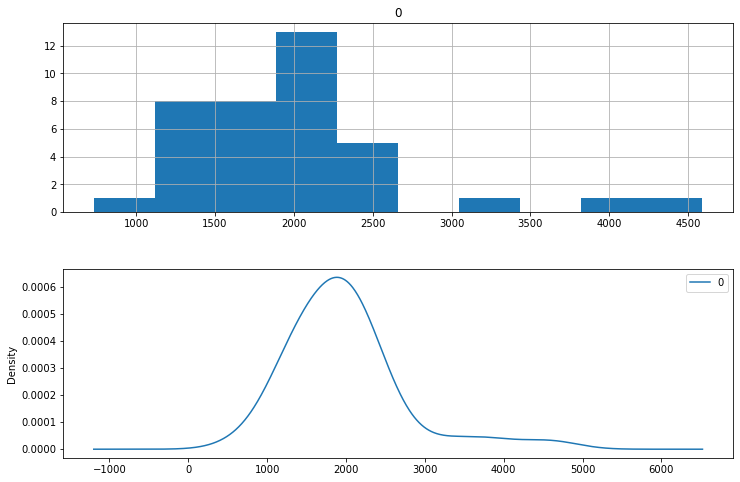


bias saved in arg_dict["bias"] for subsequent run is: 1970.9440287940276 



In [28]:
if __name__ == '__main__':
    
    # Prepare arguments for driver
    with open('filename.pickle', 'rb') as handle:
        arg_dict = pickle.load(handle)
    
    df = pd.read_csv('df.csv')
    
    # Start driver
    bias, test, predictions, model_fit = driver(df, arg_dict) 
    